In [2]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 17.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=1cf22f42363cd82eb0083422f45826111c31f2d87eb18dd0eee897b7e70982d7
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 734kB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 2.2MB 30.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210220-cp36-none-any.whl size=52292 sha256=6c465408c9bcd0a0a9ed307dd6cf794602b1dd78c20f1c3760584fe8137063b7
  Stored in directory: /root/.cache/pip/wheels/a1/af/2b/42e10bc07a70a2776e1a011d058a952db114a60f7bc8aa2199
  Created wheel for iopath: filename=iopath-0.1.4-cp36-none-any.whl size=15571 sha256=21f4739cf8abe7f613f64e47661f3cdd07417fb9246d13dc43d9e61fc0b1771b
  Stored in directory: /root/.cache/pip/wheels/54/3b/fb/25b60ef5989e3f5fd76fdc575c922e6e59066ddbd1b44756a9
Successfully built fvcore iopath
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import imgaug as ia
ia.seed(1)
from imgaug import augmenters as iaa 
import imageio
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from pathlib import Path
from google.colab import drive

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader 
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [3]:
import pandas as pd
import os

## Setup the synthetic data

In [37]:
images_dir = Path("drive/MyDrive/EdIntelligence-Neurolabs-Hackathon/common/train/syn/images/")
annotations_csv_f = Path("drive/MyDrive/EdIntelligence-Neurolabs-Hackathon/common/train/syn/annotations-detection.csv")

In [38]:
df = pd.read_csv(annotations_csv_f)
df

,Dfcmhxrn_0.jpg,239,720,297,769,canned_tuna_3
0,Dfcmhxrn_0.jpg,1573,215,1595,234,apple_red_3
1,Dfcmhxrn_0.jpg,113,545,138,633,pasta_noodlejoe_1
2,Dfcmhxrn_0.jpg,874,321,911,410,milk_3_blue
3,Dfcmhxrn_0.jpg,128,676,163,759,sugar_brown
4,Dfcmhxrn_0.jpg,314,174,354,255,can_soda_12
...,...,...,...,...,...,...
1230407,ZZzERNWk_0.jpg,795,625,834,716,milk_5_red
1230408,ZZzERNWk_0.jpg,504,610,528,674,bottle_soda_4_yellow
1230409,ZZzERNWk_0.jpg,923,300,977,414,coffee_yellow_calista
1230410,ZZzERNWk_0.jpg,1707,188,1745,272,soap_5


In [3]:
images_val_dir = Path("/content/drive/MyDrive/Hackathon-Challenge-1-Validation/")
annotations_csv_val = Path("/content/drive/MyDrive/validation-data-challenge-1.csv")

In [21]:
image_augmentations = iaa.SomeOf( 2,
    [                                
    # Scale the Images
    iaa.Affine(scale=(0.5, 1.5)),
    # Rotate the Images
    iaa.Affine(rotate=(-60, 60)),
    # Shift the Image
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),
    # Flip the Image
    iaa.Fliplr(1),
    # Increase or decrease the brightness
    iaa.Multiply((0.5, 1.5)),
    # Add Gaussian Blur
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    # Add Gaussian Noise
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
])

In [39]:
from detectron2.structures import BoxMode

class Annotations:
  def __init__(self):
    self.annotations = None
    self.categories = None
    self.categories_map_reverse = None

  def compute(self):
    if self.annotations != None:
      return self.annotations

    # first read all the information
    csv_data = {}
    with annotations_csv_f.open() as f:
      for line in f:
        image_name, xmin, ymin, xmax, ymax, label = line.rstrip().split(",")
        if image_name not in csv_data:
          csv_data[image_name] = []
        csv_data[image_name].append([xmin,ymin,xmax,ymax,label])
    print(f"Finished reading data. Images: {len(csv_data.keys())}")

    # get all the labels and sort them (use a dictionary for O(1) lookup)
    categories = []
    for anns in csv_data.values():
      for ann in anns:
        label = ann[4]
        if not label in categories:
          categories.append(label)
    categories = sorted(categories)
    print(f"First 10 categories are {categories[:10]}")
    self.categories = categories
    categories_map = {label:idx for idx,label in enumerate(categories)}
    self.categories_map_reverse = {idx:label for idx,label in enumerate(categories)}

    # convert this to the format that detectron2 wants
    data = []
    for idx, image_name in enumerate(csv_data.keys()):

      if idx >= 2000: # load more if you want!
        break

      if idx%100 == 0:
        print(f"Processed {idx} images.")
      record = {}

      filename = os.path.join(images_dir,image_name)  #str(images_dir/image_name)
      height, width = cv2.imread(filename).shape[:2]
      #imageio.imwrite(filename,image_augmentations)
      
      record["file_name"] = filename
      record["image_id"] = idx
      record["height"] = height
      record["width"] = width

      annotations = csv_data[image_name]
      objs = []
      for annotation in annotations:
        xmin, ymin, xmax, ymax, label = annotation
        objs.append({
            "bbox": [float(xmin),float(ymin),float(xmax),float(ymax)],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": categories_map[label]
        })
      record["annotations"] = objs
      data.append(record)
    
    self.annotations = data

anns = Annotations()
anns.compute()
print(anns.categories_map_reverse)
print(f"Finished loading annotations.")

Finished reading data. Images: 13200
First 10 categories are ['apple_green', 'apple_red_1', 'apple_red_2', 'apple_red_3', 'baby_food_1', 'baby_food_10', 'baby_food_2', 'baby_food_3', 'baby_food_4', 'baby_food_5']
Processed 0 images.
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.
{0: 'apple_green', 1: 'apple_red_1', 2: 'apple_red_2', 3: 'apple_red_3', 4: 'baby_food_1', 5: 'baby_food_10', 6: 'baby_food_2', 7: 'baby_food_3', 8: 'baby_food_4', 9: 'baby_food_5', 10: 'baby_food_6', 11: 'baby_food_7', 12: 'baby_food_8', 13: 'baby_food_9', 14: 'biscuits_blue', 15: 'biscuits_orange', 16: 'biscuits_red', 17: 'bottle_beer_

In [43]:
class AnnotationsValidation:
  def __init__(self):
    self.annotations = None
    self.categories = None
    self.categories_map_reverse = None

  def compute(self):
    if self.annotations != None:
      return self.annotations

    # first read all the information
    csv_data = {}
    with annotations_csv_val.open() as f:
      for line in f:
        image_name, xmin, ymin, xmax, ymax, label = line.rstrip().split(",")
        if image_name not in csv_data:
          csv_data[image_name] = []
        csv_data[image_name].append([xmin,ymin,xmax,ymax,label])
    print(f"Finished reading data. Images: {len(csv_data.keys())}")

    # get all the labels and sort them (use a dictionary for O(1) lookup)
    categories = []
    for anns in csv_data.values():
      for ann in anns:
        label = ann[4]
        if not label in categories:
          categories.append(label)
    categories = sorted(categories)
    print(f"First 10 categories are {categories[:10]}")
    self.categories = categories
    categories_map = {label:idx for idx,label in enumerate(categories)}
    categories_map_reverse = {idx:label for idx,label in enumerate(categories)}
    self.categories_map_reverse = categories_map_reverse

    # convert this to the format that detectron2 wants
    data = []
    for idx, image_name in enumerate(csv_data.keys()):

      if idx >= 2000: # load more if you want!
        break

      if idx%100 == 0:
        print(f"Processed {idx} images.")
      record = {}

      filename = str(images_val_dir/image_name)
      height, width = cv2.imread(filename).shape[:2]
      
      record["file_name"] = filename
      record["image_id"] = idx
      record["height"] = height
      record["width"] = width

      annotations = csv_data[image_name]
      objs = []
      for annotation in annotations:
        xmin, ymin, xmax, ymax, label = annotation
        objs.append({
            "bbox": [float(xmin),float(ymin),float(xmax),float(ymax)],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": categories_map[label]
        })
      record["annotations"] = objs
      data.append(record)
    
    self.annotations = data
#anns_val = AnnotationsValidation()
#anns_val.compute()

Finished reading data. Images: 2640
First 10 categories are ['apple_green', 'apple_red_1', 'apple_red_2', 'apple_red_3', 'baby_food_1', 'baby_food_10', 'baby_food_2', 'baby_food_3', 'baby_food_4', 'baby_food_5']
Processed 0 images.
Processed 100 images.
Processed 200 images.
Processed 300 images.
Processed 400 images.
Processed 500 images.
Processed 600 images.
Processed 700 images.
Processed 800 images.
Processed 900 images.
Processed 1000 images.
Processed 1100 images.
Processed 1200 images.
Processed 1300 images.
Processed 1400 images.
Processed 1500 images.
Processed 1600 images.
Processed 1700 images.
Processed 1800 images.
Processed 1900 images.


In [40]:
# let's register this dataset (unregistered if it exists.)
def register(name, load_fn, labels):
  if name in DatasetCatalog.list():
    DatasetCatalog.remove(name)
  if name in MetadataCatalog.list():
    MetadataCatalog.remove(name)
  
  DatasetCatalog.register(name, load_fn)
  MetadataCatalog.get(name).set(thing_classes=labels)

register("train", lambda:anns.annotations, anns.categories)
#register("validation",lambda:anns_val.annotations, anns_val.categories)
print("Dataset registered.")

Dataset registered.


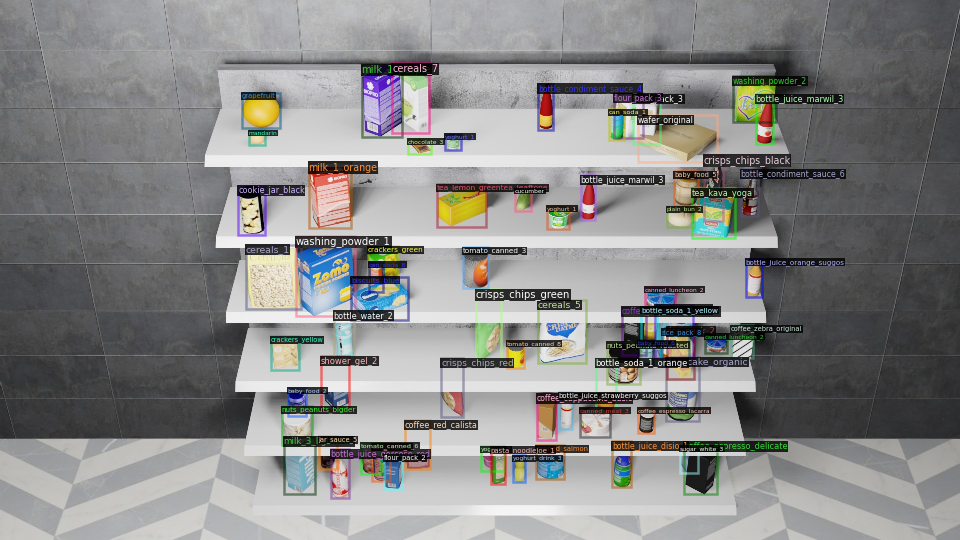

In [41]:
for d in random.sample(anns.annotations, 1):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("train"), scale=0.5)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

In [44]:
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")) # COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml
#COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "drive/MyDrive/model_final.pth" #model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 2500    
cfg.SOLVER.STEPS = []      
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(anns.categories) 

In [45]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/21 11:49:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [46]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the trained model
predictor = DefaultPredictor(cfg)

Code block below was used to evaluate the model on the validation set before the training data was made available

In [55]:
'''test_dataset_name = "validation" 
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   
cfg.DATASETS.TEST = (test_dataset_name,) 
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator(test_dataset_name, cfg, False, output_dir="./output/")
loader = build_detection_test_loader(cfg, test_dataset_name)
eval_results = inference_on_dataset(trainer.model, loader, evaluator)
print(eval_results)'''

WARNING [02/20 00:17:31 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[02/20 00:17:31 d2.evaluation.coco_evaluation]: 'validation' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[02/20 00:17:31 d2.data.datasets.coco]: Converting annotations of dataset 'validation' to COCO format ...)
[02/20 00:17:31 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/20 00:18:01 d2.data.datasets.coco]: Conversion finished, #images: 2000, #annotations: 184496
[02/20 00:18:01 d2.data.datasets.coco]: Caching COCO format annotations at './output/validation_coco_format.json' ...
[02/20 00:18:05 d2.data.build]: Distribution of instances among all 330 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|  app

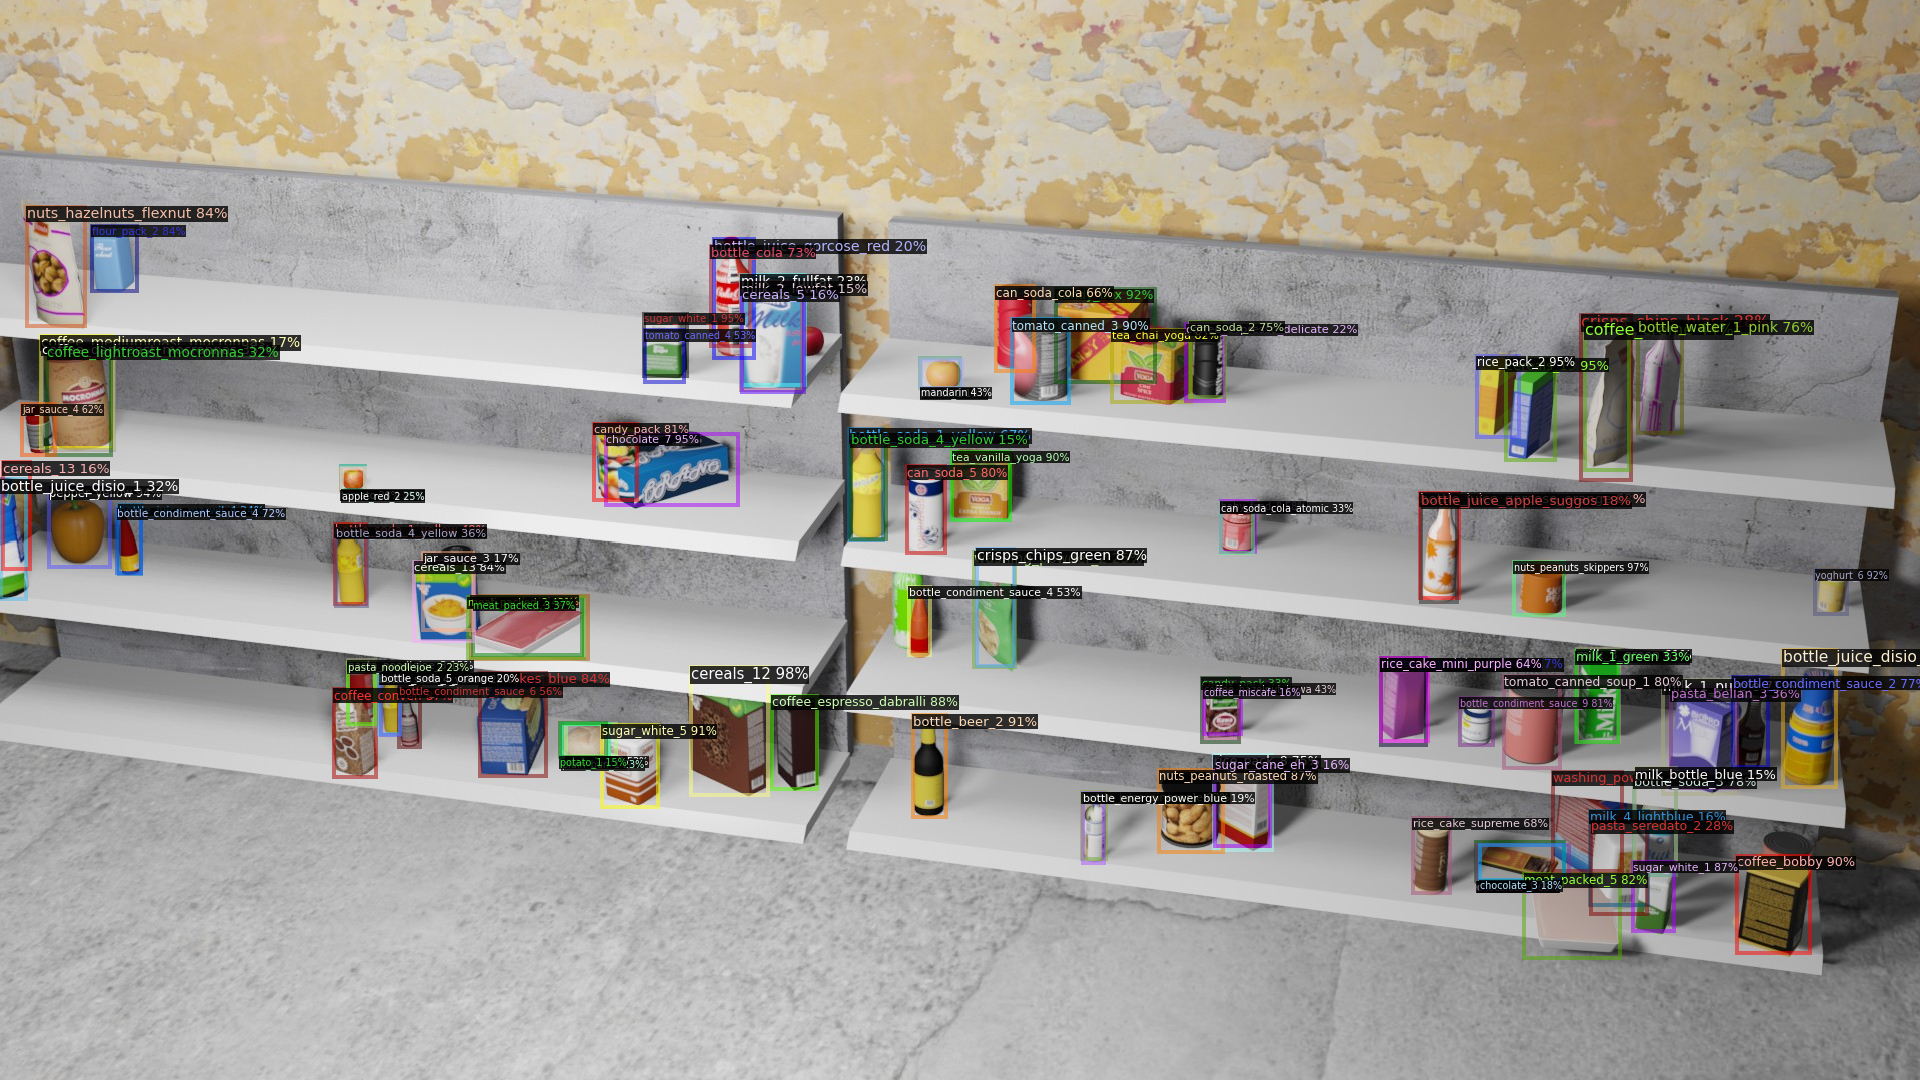

In [56]:
# visualize inference on some images
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0 # if you want to allow predictions with lower accuracy
predictor = DefaultPredictor(cfg)
for d in random.sample(DatasetCatalog.get(test_dataset_name), 1):
  img = cv2.imread(d["file_name"])
  outputs = predictor(img)
  visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(test_dataset_name), scale=1)
  # out = visualizer.draw_dataset_dict(d) # these are the ground truths 
  out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])

In [47]:
images_test_dir = 'drive/MyDrive/EdIntelligence-Neurolabs-Hackathon/challenge-1/test/images/'

In [49]:
outputs = []
file_names = []
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0
for filename in os.listdir(images_test_dir):
  image = cv2.imread(os.path.join(images_test_dir,filename))
  outputs.append(predictor(image))
  file_names.append(filename)
print(len(outputs))

1000


In [50]:
print(file_names)
print((outputs[0]["instances"].pred_classes.cpu().numpy()))
array = outputs[0]["instances"].pred_boxes.tensor.cpu().numpy()
array = np.array(array,dtype=np.int32)[0]
print(array)

['AFWXWEaE_0.jpg', 'AIhATvuM_0.jpg', 'ahTXKHNd_0.jpg', 'AGXpRAay_0.jpg', 'abAnNYEi_0.jpg', 'anfDqowG_0.jpg', 'AOfOlbSQ_0.jpg', 'ApXOhdHV_0.jpg', 'aqISAevX_0.jpg', 'aQGqvsIs_0.jpg', 'aqYfappg_0.jpg', 'aNZXHNfQ_0.jpg', 'AstMHKZh_0.jpg', 'ATseIXEo_0.jpg', 'AtwYsSsR_0.jpg', 'AubcHYyg_0.jpg', 'ARDJtogo_0.jpg', 'AuFmBDBT_0.jpg', 'aVIeSzcE_0.jpg', 'avMQDVIF_0.jpg', 'AwApOiYH_0.jpg', 'AXxuqcRX_0.jpg', 'aUSCEXOD_0.jpg', 'bDTsPBQI_0.jpg', 'ayTpkQWi_0.jpg', 'BEEtwzcV_0.jpg', 'BHEVGKch_0.jpg', 'bHmEqWHC_0.jpg', 'bCtSQTDL_0.jpg', 'BRfEwsuY_0.jpg', 'BryHRYzp_0.jpg', 'BnMvCRYS_0.jpg', 'bJmQfabh_0.jpg', 'bsZRICtR_0.jpg', 'BlXixbSt_0.jpg', 'aemnyrEi_0.jpg', 'aGBertiy_0.jpg', 'AfOKZIlM_0.jpg', 'ADwuhoQx_0.jpg', 'aaGWwzWb_0.jpg', 'AfOwhtSH_0.jpg', 'AkOJHoGW_0.jpg', 'aHbOxXoc_0.jpg', 'AIufseIJ_0.jpg', 'agnVkfCX_0.jpg', 'AgeuMngB_0.jpg', 'AiiJujwL_0.jpg', 'AwatUcGD_0.jpg', 'aqUIXbEP_0.jpg', 'ATFnmQdq_0.jpg', 'ArOSXoFk_0.jpg', 'aPWLXgbL_0.jpg', 'ALvQvllu_0.jpg', 'bkrppeet_0.jpg', 'BfovSCki_0.jpg', 'BJPdcRei

In [51]:
all_lists = []
for i in range(len(outputs)):
  bb_array = outputs[i]["instances"].pred_boxes.tensor.cpu().numpy()
  bb_array = np.array(bb_array,dtype=np.int32)
  for idx in range(len(outputs[i]["instances"].pred_classes.cpu().numpy())):
    all_lists.append([file_names[i],bb_array[idx][0],bb_array[idx][1],bb_array[idx][2],bb_array[idx][3],outputs[i]["instances"].pred_classes.cpu().numpy()[idx]])
df = pd.DataFrame(all_lists,columns=["ImageId","xmin","ymin","xmax","ymax","ClassLabels"])
df.head(100)



,ImageId,xmin,ymin,xmax,ymax,ClassLabels
0,AFWXWEaE_0.jpg,1142,527,1217,671,173
1,AFWXWEaE_0.jpg,1128,826,1176,845,112
2,AFWXWEaE_0.jpg,734,760,770,835,88
3,AFWXWEaE_0.jpg,690,565,746,668,114
4,AFWXWEaE_0.jpg,1230,256,1272,319,5
...,...,...,...,...,...,...
95,AFWXWEaE_0.jpg,721,118,748,138,251
96,AFWXWEaE_0.jpg,722,119,749,139,250
97,AFWXWEaE_0.jpg,722,118,748,138,252
98,AFWXWEaE_0.jpg,692,201,779,327,119


In [52]:
df["ClassLabels"] = df["ClassLabels"].apply(lambda x: anns.categories_map_reverse[x] )
df

,ImageId,xmin,ymin,xmax,ymax,ClassLabels
0,AFWXWEaE_0.jpg,1142,527,1217,671,crisps_chips_blue
1,AFWXWEaE_0.jpg,1128,826,1176,845,carrot
2,AFWXWEaE_0.jpg,734,760,770,835,can_soda_6
3,AFWXWEaE_0.jpg,690,565,746,668,cereals_10
4,AFWXWEaE_0.jpg,1230,256,1272,319,baby_food_10
...,...,...,...,...,...,...
99983,BGHqNSvv_0.jpg,939,648,1037,691,chocolate_3
99984,BGHqNSvv_0.jpg,658,126,746,255,milk_1_orange
99985,BGHqNSvv_0.jpg,327,141,362,222,pear_3
99986,BGHqNSvv_0.jpg,1240,1,1302,40,candy_box_chocolate


In [53]:
df.to_csv("drive/MyDrive/submission-2-challenge-1-faster_rcnn_R_50_FPN_3x-no-augment.csv",header=False,index=False)